# Estimating-the-correlation-length 

* A central parameter for the DIVAnd analysis is the correlation lenght
* It determines whether two points separated by a given distance are correlated or not
* DIVAnd includes several tools to estimate the correlation length
* We will start with a 2D case and consider the 3D case

In [1]:
using Base.Test
import divand
using PyPlot

Download the file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file based on the World Ocean Database.

In [2]:
fname = "Salinity.bigfile"

if !isfile(fname)
    download("https://b2drop.eudat.eu/s/Bv9Fj0YGC0zp2vn/download",fname)
end

Load the data

In [3]:
value,lon,lat,depth,time,ids = divand.loadbigfile(fname);

`mincount` is the minimum number of observations ber distance bin and the call to `srand` ensures a reproducible sequence of random numbers.

In [4]:
mincount = 10000
srand(12345) # this can be any number

MersenneTwister(UInt32[0x00003039], Base.dSFMT.DSFMT_state(Int32[-870096391, 1072918504, -1812426662, 1073255081, -733866021, 1073404543, 807620846, 1073368448, 1919433844, 1072852359  …  -362113007, 1073100625, -166402106, 1073460158, -1907020342, 721295190, -750225566, -1300227565, 382, 0]), [1.15902, 1.25303, 1.94892, 1.69106, 1.41056, 1.58889, 1.78545, 1.9268, 1.96485, 1.3349  …  1.65527, 1.39214, 1.56892, 1.37233, 1.06004, 1.20382, 1.10413, 1.84584, 1.98787, 1.02959], 382)

## 2D case

* First lets consider only the data on a 2D surface (longitude and latitude)
* We use the function `divand.fit_isotropic`


In [5]:
?divand.fit_isotropic

```
var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount;
                           alpha = divand.alpha_default(length(x)),
                           len = 1.,
                           var0 = 1.,
                           minlen = 0.,
                           maxlen = 10.,
                           minvar0 = 0.,
                           maxvar0 = 10.,
                           tolrel = 1e-4,
                           maxpoints = 1000000,
                           distfun = (xi,xj) -> sqrt(sum(abs2,xi-xj))),
                           progress = (var,len,fitness) -> nothing
                       )
```

Determines the optimal correlation length `len` and variance (for a separation distance approaching zero) `var0` of a cloud of data points with value `v` and coordiantes `x` (tuple of vectors with the coordinates).

The function can find the solution corresponding to  a local minimum which is not necessarily the global minimum.

See also `empiriccovar` for future information about the output parameters.

Optional input parameters:

  * `alpha`: if one correlation length is forced to zero during the anaylsis the values of alpha sould be set using the effective dimension. For example, if a 2D-analysis is simulated by forcing the vertical correlation length to zero, then alpha should be set to `[1,2,1]`, otherwise alpha will be `[1,3,3,1]` (for for any proper 3D analysis).
  * `len`: initial value for the correlation length
  * `var0`: initial value of the variance
  * `minlen`, `maxlen`: minimum and maximum value for the correlation length
  * `minvar0`, `maxvar0`: minimum and maximum value for the variance
  * `tolrel`: relative tolerance for the optimizer
  * `maxpoints`: maximum number of data points considered
  * `distfun`: function to compute the distance between point `xi` (vector) and   `xj`. Per default `distun` is the Eucedian distance  `(xi,xj) -> sqrt(sum(abs2,xi-xj)))`.
  * `progress`: call-back function to show the progress of the optimization with  the input parameters `var`, `len` and `fitness` (all scalars).

The length-scale parameters and the variance have the corresponding units from  the `x` and `v`. It is therefore often necessary to provide reasonable values  for these default parameters.

If the lower bound `minlen` is too small, then you might get the following error:

```
AmosException with id 4: input argument magnitude too large, complete loss of accuracy by argument reduction.
```

In these case, increase `minlen`.


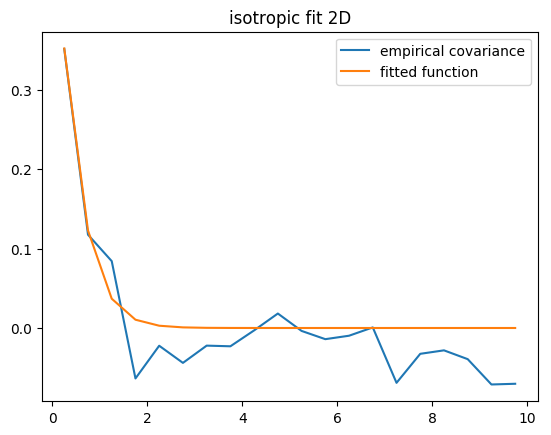

PyObject Text(0.5,1,u'isotropic fit 2D')

In [6]:
# surface values for the month January
sel = (depth .> 10) .& Dates.month.(time) .== 1;
x = (lon[sel],lat[sel]);
v = value[sel] - mean(value[sel]);
distbin = 0:0.5:10

var0,len,distx,covar,fitcovar = divand.fit_isotropic(x,v,distbin,mincount)


figure()
plot(distx,covar, label = "empirical covariance")
plot(distx,fitcovar, label = "fitted function")
legend()
title("isotropic fit 2D")

The data from the file `Salinity.bigfile` is already interpolated on z levels which makes it not ideal to explore the vertical correlation.
The file `WOD-Salinity-Provencal.nc` is the salinity data from the World Ocean Database for the Provençal Basin (Mediterranean Sea).

The resulting correlation length can fluctuate a bit because the correlation is based on a collection of random pairs. Increasing `nmean` can be the estimation of the correlation more robust.

In [ ]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

value,lon,lat,depth,time,ids = divand.loadobs(Float64,filename,"Salinity")

divand.checkobs((lon,lat,depth,time),value,ids)


sel = (Dates.month.(time) .== 1)
x = (lon[sel],lat[sel],depth[sel]);
v = value[sel]
z = [0.,10,100,200,300,400,500,700,1000,1500]


srand(1234);
@time lenz,infoz = divand.fitvertlen(x,v,z,len0 = 300., nmean = 500, distbin = collect([0.:50:400; 500:100:600]))


srand(1234);
@time lenxy,infoxy = divand.fithorzlen(x,v,z,len0 = 3., nmean = 500, distbin = collect(0.:0.1:6))

